In [1]:
# This is a demonstration of the mass sheet degeneracy in its
# simplest form

In [2]:
# Import some modules and set some defaults
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import grale.lenses as lenses
import grale.plotutil as plotutil
import grale.cosmology as cosmology
import grale.feedback as feedback 
import grale.images as images
from grale.constants import *

feedback.setDefaultFeedback("none")
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)

V = lambda x,y: np.array([x,y],dtype=np.double)
LI = plotutil.LensInfo

In [3]:
# The cosmological model we're going to use
cosm = cosmology.Cosmology(0.7,0.3,0,0.7)

In [4]:
# Set redshifts and calculate angular diameter distances
z_d, z_s = 0.5, 2.0
Dd = cosm.getAngularDiameterDistance(z_d)
Dds = cosm.getAngularDiameterDistance(z_d, z_s)
Ds = cosm.getAngularDiameterDistance(z_s)

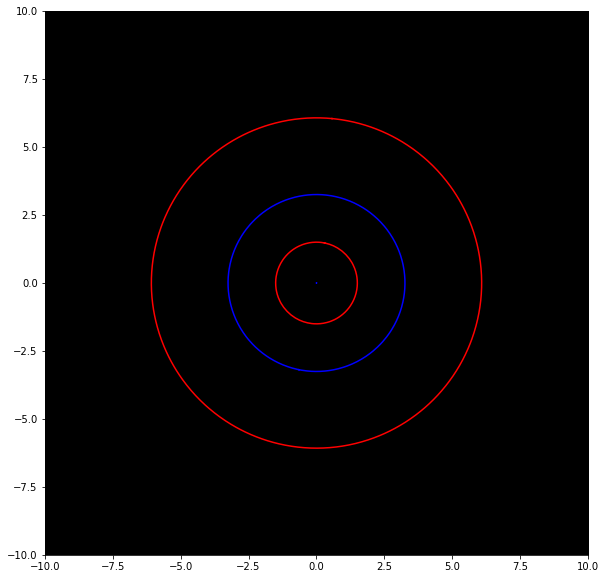

In [5]:
# As the base lens we're going to use a NSIS lens; below we'll create a
# mass sheet degenerate version based on this model
baseLens = lenses.NSISLens(Dd, {"velocityDispersion": 600000, "coreRadius": 0.5*ANGLE_ARCSEC})
lensInfo = LI(baseLens, size=20*ANGLE_ARCSEC, Ds=Ds, Dds=Dds)
    
plotutil.plotDensityInteractive(lensInfo, visJSoptions= { "zMin": 0});
plt.figure(figsize=(10,10))
plotutil.plotImagePlane(lensInfo);

In [6]:
# Calculate the Einstein radius from the critical lines. Here, the
# outer critical line is the one with index 0. We'll just average
# the distance of each point on the critical line to get the estimate
# of the Einsteint radius
lines = lensInfo.getImagePlane().getCriticalLines()
rs = [ sum(pt**2)**0.5 for pt in lines[0] ]
r_einstein = 0.5*(np.max(rs) + np.min(rs))/ANGLE_ARCSEC
print("r_einstein =", r_einstein, "arcsec")

r_einstein = 6.076335343017446 arcsec


In [7]:
# Calculate the critical density for a source at the specified redshift
critDens = lensInfo.getLens().getCriticalDensity(Ds, Dds)
print("Critical density:", critDens, "kg/m^2")

Critical density: 4.341745756808096 kg/m^2


In [8]:
# For the mass sheet degeneracy, we need a sheet with the critical density
# for the source distances. Any new lens that follow this recipe:
#
#    newLens = _lambda * baseLens + (1.0 - _lambda) * sheet
#
# will produce the same images for a rescaled source. Here, we'll use
# a CompositeLens model to construct such a new lens
_lambda = 0.7
sheet = lenses.MassSheetLens(Dd, { "density": critDens })
msd = lenses.CompositeLens(Dd, [
    { "factor": _lambda, "x": 0, "y": 0, "angle": 0, "lens": baseLens },
    { "factor": (1-_lambda), "x": 0, "y": 0, "angle": 0, "lens": sheet }
])

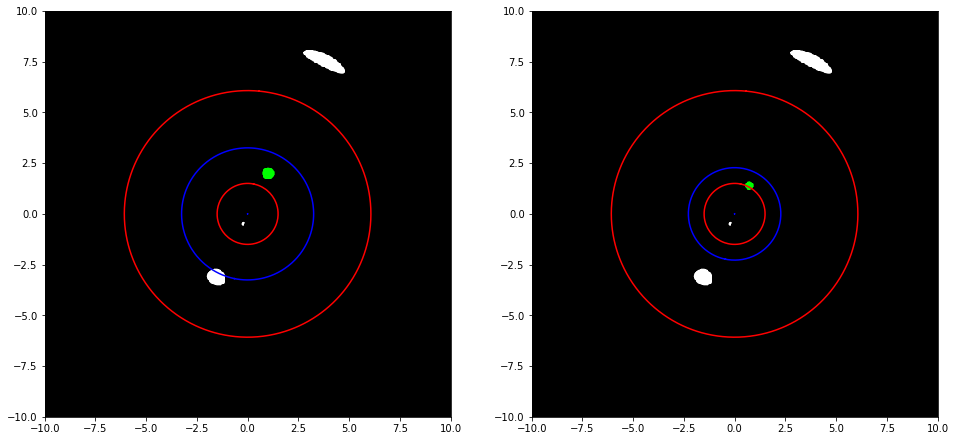

In [9]:
# Here we'll plot the density and the image planes. As you'll see in the density,
# the central peak is lower than in the original lens (due to the rescaling); also,
# the offset along the z-axis is higher, due to the addition of the mass sheet
#
# We'll calculate the images for the base lens and the new lens; as the source
# plane has been rescaled due to the mass sheet degeneracy, we use a rescaled
# source position and size. You'll see that in the two cases, the same images are
# generated. Note that the rescaling of the source plane is also apparent when
# comparing the sizes of the caustics.
msdLensInfo = LI(msd, size=20*ANGLE_ARCSEC, Ds=Ds, Dds=Dds)
    
plotutil.plotDensityInteractive(msdLensInfo, visJSoptions= { "zMin": 0});

origPos, origSize = V(1,2)*ANGLE_ARCSEC, 0.3*ANGLE_ARCSEC
newPos, newSize = origPos*_lambda, origSize*_lambda

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plotutil.plotImagePlane(lensInfo, [images.CircularSource(origPos, origSize)]);
plt.subplot(1,2,2)
plotutil.plotImagePlane(msdLensInfo, [images.CircularSource(newPos, newSize)]);

In [10]:
# As before, calculate the Einstein radius. This yields the same value
# as for the base lens.
lines = msdLensInfo.getImagePlane().getCriticalLines()
rs = [ sum(pt**2)**0.5 for pt in lines[0] ]
r_einstein_msd = 0.5*(np.max(rs) + np.min(rs))/ANGLE_ARCSEC
print("r_einstein_msd =", r_einstein_msd, "arcsec")

r_einstein_msd = 6.076335343017446 arcsec


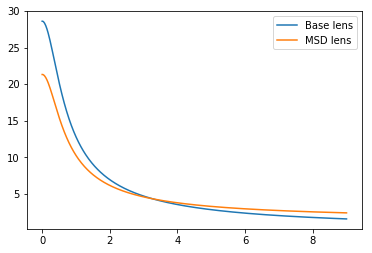

In [11]:
# To better visualize the rescaling of the mass density and addition of a
# sheet of mass, we'll also plot the circularly averaged profiles.
plotutil.plotAverageDensityProfile(lensInfo, thetaMax = 9*ANGLE_ARCSEC, label="Base lens");
plotutil.plotAverageDensityProfile(msdLensInfo, thetaMax = 9*ANGLE_ARCSEC, label="MSD lens");
plt.legend();